<a href="https://colab.research.google.com/github/Togarucharitha/facial-expression-recognition/blob/main/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Download and Setup

We are downloading the dataset from https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge using the Kaggle API. This dataset is used for facial expression recognition.

We are unzipping the downloaded dataset into a folder named fer2013_data so that we can easily access and use the files for training our facial expression recognition model.

In [ ]:
# Create a Kaggle directory and move the token there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

# Install kaggle API
!pip install -q kaggle

# Download the dataset using the dataset or competition name
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Unzip the downloaded dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d fer2013_data


 87% 248M/285M [00:00<00:00, 722MB/s] 
100% 285M/285M [00:00<00:00, 778MB/s]


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order.

The training set consists of 28,709 examples.

In [ ]:
import pandas as pd
arr=pd.read_csv('/content/fer2013_data/train.csv')
arr.head(1)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...


In [ ]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('/content/fer2013_data/train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


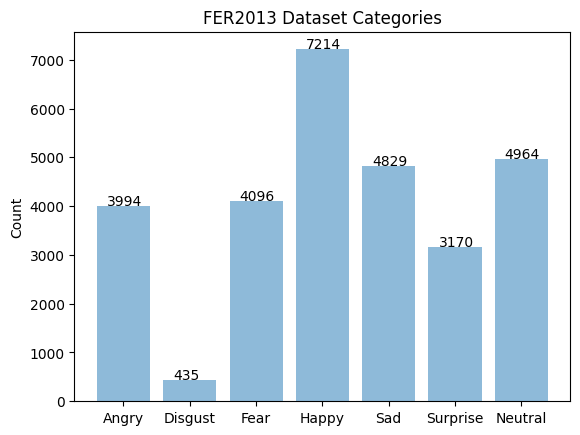

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)
    plt.text(label-0.25, count+15, str(count))

# Draw histogram
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

Label is: 5


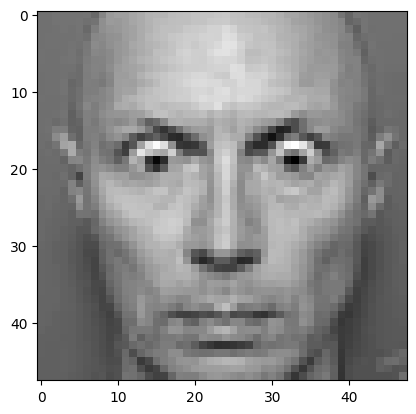

In [ ]:
image = x_train[15]
label = y_train[15]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

We are taking x_train and y_train and splitting 20% of it into the test set. This helps us evaluate the model's performance on unseen data.

We are normalizing the pixel values of the images by dividing them by 255.0 so that the values lie between 0 and 1. This improves the training performance and stability of our neural network.

We are reshaping the training and testing data into the shape (number of samples, 48, 48, 1) because the images are 48x48 pixels in grayscale (1 channel), and this is the expected input shape for a convolutional neural network (CNN).

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


# VGG-Inspired Convolutional Model Breakdown

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version: 2.18.0


We are building a Convolutional Neural Network (CNN) model inspired by the VGG-Net architecture using the Sequential API from Keras.
VGG-Net is a deep CNN model known for its simplicity, where multiple convolutional layers with small (3×3) filters are stacked together with increasing depth, followed by max pooling and fully connected layers. It is widely used for image classification tasks due to its effectiveness in capturing hierarchical features.

**Implementing VGG-Inspired CNN Architecture**

1st Convolutional Block
We are adding two convolutional layers with 64 filters of size (3, 3), using ReLU activation.
We apply Batch Normalization after each convolution layer to stabilize learning.
Then we reduce spatial dimensions using MaxPooling2D and apply Dropout to prevent overfitting.

2nd Convolutional Block
In this block, we repeat the structure with 128 filters: two Conv2D layers, each followed by Batch Normalization, then MaxPooling and Dropout.

3rd Convolutional Block
We increase the number of filters to 256 in this block.
We again use two convolution layers, each followed by Batch Normalization, then apply MaxPooling2D and Dropout.

4th Convolutional Block
Here, we use 512 filters with two convolution layers, Batch Normalization, MaxPooling, and Dropout.


This follows the VGG-style pattern of deepening the network with more filters at each block.

Fully Connected Layers
After flattening the feature maps , we use three Dense layers with 512, 256, and 64 neurons respectively.
Each Dense layer uses ReLU activation and is followed by Dropout to regularize the model.

In [ ]:
cnn_model = Sequential()

# 1st convolution layer
cnn_model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 2nd convolution layer
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 3rd convolution layer
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 4th convolution layer
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# Fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(7, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,102,791 (19.47 MB)

 Trainable params: 5,098,951 (19.45 MB)

 Non-trainable params: 3,840 (15.00 KB)

To ensure that the training process is efficient and avoids overfitting or wasting computation on unnecessary epochs, we use callbacks.

We use EarlyStopping to prevent overfitting and save training time.

We also use ReduceLROnPlateau to dynamically adjust the learning rate during training.

We train the model on the training dataset with the configuration:

Batch size of 64

Epochs set to 100, but actual training may stop earlier due to EarlyStopping.

Callbacks included to optimize training dynamics automatically.



In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = cnn_model.fit(x_train,
                        y_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - accuracy: 0.2268 - loss: 2.0431 - val_accuracy: 0.2423 - val_loss: 1.9518 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.3148 - loss: 1.6946 - val_accuracy: 0.3034 - val_loss: 1.8340 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4152 - loss: 1.4940 - val_accuracy: 0.4122 - val_loss: 1.5503 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4681 - loss: 1.3833 - val_accuracy: 0.4922 - val_loss: 1.3397 - learning_rate: 0.0010
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4996 - loss: 1.3183 - val_accuracy: 0.4911 - val_loss: 1.3063 - learning_rate: 0.0010
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.5352 - loss: 1.2541 - val_accuracy: 0.4941 - val_loss: 1.3447 - learning_rate: 0.0010
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.5

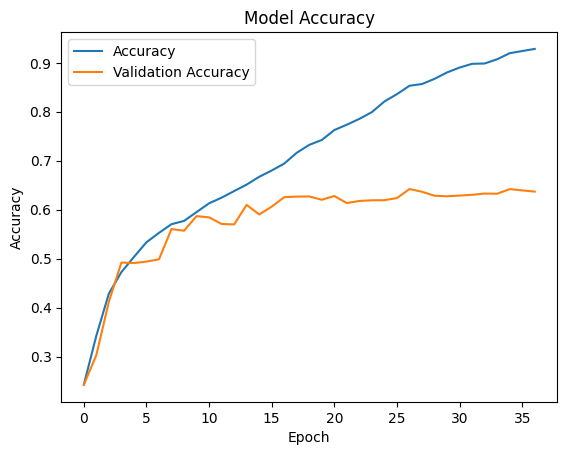

In [ ]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
# Evaluate the model before improvement
_, score_before_improvement = cnn_model.evaluate(x_test, y_test)
print('Score before improvement: {}'.format(score_before_improvement))

180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6420 - loss: 1.7043
Score before improvement: 0.637060284614563


# Model Optimization Techniques

We make predictions on the test data.For each image, we compare the predicted label with the actual label.If the prediction is incorrect, we consider that image a hard example.

We collect these hard examples (x_hard) and their true labels (y_hard) into separate arrays.

The model learns better when it's exposed again to the cases it previously failed on. This helps in reducing errors in future predictions and leads to a more robust and generalizable model.



In [ ]:
# Generate hard data
hard_images = []
hard_labels = []

# Make predictions
predictions = cnn_model.predict(x_test)
for i, v in enumerate(predictions):
    y_predict = numpy.argmax(v)
    y_real = y_train[i]
    if y_predict != y_real:
        # If predict incorrectly, append to array
        image = x_train[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = numpy.array(hard_images)
y_hard = numpy.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

We split the hard data into training and validation sets and retrain the model on this focused subset.

In [ ]:
# Train the model on hard data
x_hard_train, x_hard_test, y_hard_train, y_hard_test = train_test_split(x_hard, y_hard, test_size=0.2)
history = cnn_model.fit(x_hard_train,
                        y_hard_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_hard_test, y_hard_test),
                        callbacks=[early_stopping, reduce_learning_rate])

To further improve the performance and generalization ability of the CNN model, we apply data augmentation. This technique artificially expands the training dataset by creating slightly modified versions of existing images.

Here, we also train the model again using the augmented data to balance out performance and ensure that the model can handle diverse input cases effectively.

In [ ]:
# Perform data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train,
                           y_train,
                           batch_size=64)

# Train the model again to balance out
history = cnn_model.fit(flow,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

After all refinements, we evaluate the model to check its final accuracy on the test set.

In [ ]:
# Evaluate the model after improvement
_, score_after_improvement = cnn_model.evaluate(x_test, y_test)
print('Score after improvement: {}'.format(score_after_improvement))

# Custom Image Prediction Using Trained CNN Model

Once the CNN model has been trained and validated, it can be used to predict facial expressions from external images.

I tested the trained CNN model on images sourced from the internet

In [ ]:
from google.colab import files
uploaded = files.upload()

import torch
import torchvision.transforms as transforms
from PIL import Image

# Load and preprocess the image
image_path7 = 'test_image.png'  # Upload image to Colab and use the filename
image = Image.open(image_path).convert('L')  # Grayscale for 1-channel CNNs

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0).numpy()  # Shape: (1, 1, 48, 48)

input_tensor = input_tensor.reshape(1, 48, 48, 1) # Reshape to (1, 48, 48, 1)

output = cnn_model.predict(input_tensor)
predicted_class = np.argmax(output)

# Interpret the output
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("Predicted class:", classes[predicted_class])